#Time series classification

We have a training data set of 214 time series (each size 1024), each belonging to one of 39 possible classes.

The test set contains 1896 time series. Goal: improve the accuracy of 36.20%.


See:  https://timeseriesclassification.com/description.php?Dataset=Phoneme

Upload the files 'Phoneme_TEST.arff' and 'Phoneme_TRAIN.arff' into the local folder. (In colab, upload them into the folder 'content', see left panel.) 

# Import packages:

In [1]:
import numpy as np
import pandas as pd  #pd.show_versions()
import matplotlib.pylab as plt
#import seaborn as sns
#from datetime import datetime
#from datetime import timedelta  
#import pickle
import warnings
#import math

import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import StandardScaler

from scipy.fft import fft
from scipy.io import arff
import scipy.stats as stats

import keras
from keras.layers import TimeDistributed, LSTM, Concatenate, Input, MaxPooling1D, MaxPooling2D, Flatten, Dropout, Conv1D, Conv2D, Activation, Dense
from keras.models import Sequential

#Load data

Shape of training x-data: (214, 1024)
Shape of test x-data: (1896, 1024)
Shape of training y-data: (214,)
Shape of test y-data: (1896,)


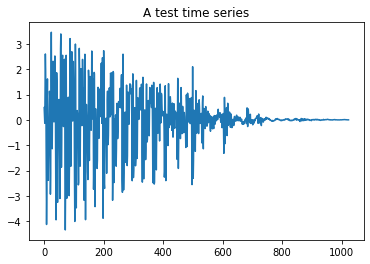

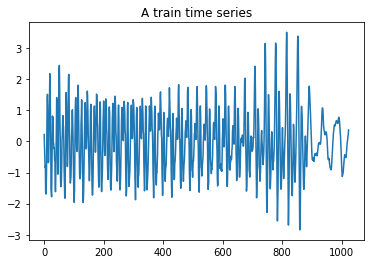

In [2]:
phoneme_test = arff.loadarff('Phoneme_TEST.arff')
df_test = pd.DataFrame(phoneme_test[0])


phoneme_train = arff.loadarff('Phoneme_TRAIN.arff')
df_train = pd.DataFrame(phoneme_train[0])

#df_train.head()

phoneme_train_x = df_train.to_numpy()
phoneme_train_y = phoneme_train_x[:,1024]
phoneme_train_x = phoneme_train_x[:,0:1024]

phoneme_test_x = df_test.to_numpy()
phoneme_test_y = phoneme_test_x[:,1024]
phoneme_test_x = phoneme_test_x[:,0:1024]

phoneme_test_x = phoneme_test_x.astype(np.float32)
phoneme_train_x = phoneme_train_x.astype(np.float32)


for j in range(0, len(phoneme_train_y)):
    phoneme_train_y[j] = int(phoneme_train_y[j].decode('utf-8'))-1
for j in range(0, len(phoneme_test_y)):
    phoneme_test_y[j] = int(phoneme_test_y[j].decode('utf-8'))-1

phoneme_test_y = phoneme_test_y.astype(np.float32)
phoneme_train_y = phoneme_train_y.astype(np.float32)

print("Shape of training x-data: " + str(phoneme_train_x.shape))
print("Shape of test x-data: " + str(phoneme_test_x.shape))
print("Shape of training y-data: " + str(phoneme_train_y.shape))
print("Shape of test y-data: " + str(phoneme_test_y.shape))

plt.plot(phoneme_test_x[0,:])
plt.title("A test time series")
plt.show()
plt.plot(phoneme_train_x[0,:])
plt.title("A train time series")
plt.show()

# Transfer the classes 0,1,...39 into one-hot encoded vectors.
ph_y_train_hot = keras.utils.to_categorical(phoneme_train_y, 39)
ph_y_test_hot = keras.utils.to_categorical(phoneme_test_y, 39)

We can listen to a phoneme as follows:

In [3]:
from IPython.display import Audio
display(Audio(phoneme_train_x[125,:], rate=11025  ))

# Fourier transform:

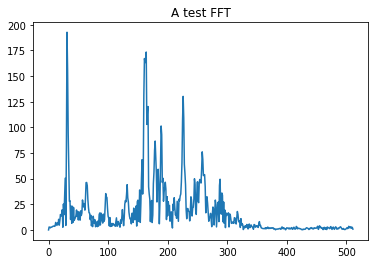

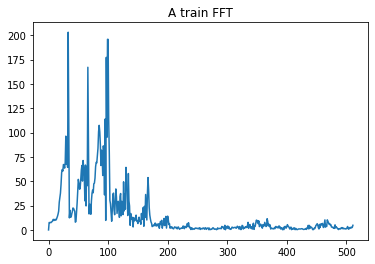

In [4]:
# For each time series, we compute (the absolute value of) the Fourier transform.
fft_train = np.zeros([len(phoneme_train_x), int(len(phoneme_train_x[0,:])/2)])
fft_test = np.zeros([len(phoneme_test_x), int(len(phoneme_train_x[0,:])/2)])

for k in range(0,len(phoneme_train_x)):
    yf = fft(phoneme_train_x[k,:])
 #xf = fftfreq(N, 1 / SAMPLE_RATE)
    fft_train[k,:] =  np.abs(yf[0:int(len(yf)/2)])
for k in range(0,len(phoneme_test_x)):
    yf = fft(phoneme_test_x[k,:])
 #xf = fftfreq(N, 1 / SAMPLE_RATE)
    fft_test[k,:] =   np.abs(yf[0:int(len(yf)/2)])


plt.plot(fft_test[0,:])
plt.title("A test FFT")
plt.show()
plt.plot(fft_train[0,:])
plt.title("A train FFT")
plt.show()

#Random Forest Classifier on the Fourier transform

Random forest classifier on the Fourier transform:

In [5]:
clf=RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 50, bootstrap = False)
clf.fit(fft_train,phoneme_train_y)
y_pred=clf.predict(fft_test)
prob_best_clf_fft=clf.predict_proba(fft_test)
# Model Accuracy, how often is the classifier correct?
print("RFC on FFT, accuracy:",metrics.accuracy_score(phoneme_test_y, y_pred))
prob_best_clf_fft_train = clf.predict_proba(fft_train)
y_pred=clf.predict(fft_train)
print("RFC on FFT, train accuracy:",metrics.accuracy_score(phoneme_train_y, y_pred))


RFC on FFT, accuracy: 0.26529535864978904
RFC on FFT, train accuracy: 1.0


The hyperparamters in the last cell have been determined by a search (takes about 15 minutes):

see https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
'''
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(fft_train, phoneme_train_y)

y_pred=rf_random.predict(fft_test)

prob_best_clf_fft = rf_random.predict_proba(fft_test)

print("Best parameters: " + str(rf_random.best_params_))
print("FFT Accuracy:",metrics.accuracy_score(phoneme_test_y, y_pred))
'''

The short Fourier transform might have more prediction power:

(see http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

We split the time series into (posibly overlapping) intervals and compute a Fourier transform for each interval.

In [7]:
number_intervals = 4
size_interval = int(1024/number_intervals)
fft_train_short = np.zeros([len(phoneme_train_x), int(len(phoneme_train_x[0,:])/(number_intervals*2)),number_intervals])
fft_test_short = np.zeros([len(phoneme_test_x), int(len(phoneme_train_x[0,:])/(number_intervals*2)),number_intervals])
fft_train_short_conc = np.zeros([len(phoneme_train_x), int(len(phoneme_train_x[0,:])/2)])
fft_test_short_conc = np.zeros([len(phoneme_test_x), int(len(phoneme_train_x[0,:])/2)])
for k in range(0,len(phoneme_train_x)):
    shorts = []
    for inte in range(0, number_intervals):
      yf = fft(phoneme_train_x[k,inte*size_interval:(inte+1)*size_interval])
      fft_train_short[k,:,inte] =  np.abs(yf[0:int(len(yf)/2)])
      shorts.append(fft_train_short[k,:,inte])
    fft_train_short_conc[k,:] = np.concatenate(shorts)
for k in range(0,len(phoneme_test_x)):
    shorts = []
    for inte in range(0, number_intervals):
      yf = fft(phoneme_test_x[k,inte*size_interval:(inte+1)*size_interval])
      fft_test_short[k,:,inte] =  np.abs(yf[0:int(len(yf)/2)])
      shorts.append(fft_test_short[k,:,inte])
    fft_test_short_conc[k,:] = np.concatenate(shorts)

number_intervals = 17
size_interval = 384
length_shift = int((1024 -  size_interval) / (number_intervals-1))
# For each time series, we compute (the absolute value of) the Fourier transform.
fft_train_short2 = np.zeros([len(phoneme_train_x), int(size_interval/2),number_intervals])
fft_test_short2 = np.zeros([len(phoneme_test_x), int(size_interval/2),number_intervals])
fft_train_short_conc2 = np.zeros([len(phoneme_train_x), int(number_intervals*size_interval/2)])
fft_test_short_conc2 = np.zeros([len(phoneme_test_x), int(number_intervals*size_interval/2)])
for k in range(0,len(phoneme_train_x)):
    list_short = []
    for i in range(0, number_intervals):
      yf = fft(phoneme_train_x[k,i*length_shift: i*length_shift + size_interval])
      fft_train_short2[k,:,i] =  np.abs(yf[0:int(len(yf)/2)])
      list_short.append(fft_train_short2[k,:,i])
    fft_train_short_conc2[k,:] = np.concatenate(list_short)

for k in range(0,len(phoneme_test_x)):
    list_short = []
    for i in range(0, number_intervals):
      yf = fft(phoneme_test_x[k,i*length_shift: i*length_shift + size_interval])
      fft_test_short2[k,:,i] =  np.abs(yf[0:int(len(yf)/2)])
      list_short.append(fft_test_short2[k,:,i])
    fft_test_short_conc2[k,:] = np.concatenate(list_short)

number_intervals = 17
size_interval = 256
length_shift = int((1024 -  size_interval) / (number_intervals-1))
# For each time series, we compute (the absolute value of) the Fourier transform.
fft_train_short3 = np.zeros([len(phoneme_train_x), int(size_interval/2),number_intervals])
fft_test_short3 = np.zeros([len(phoneme_test_x), int(size_interval/2),number_intervals])
fft_train_short_conc3 = np.zeros([len(phoneme_train_x), int(number_intervals*size_interval/2)])
fft_test_short_conc3 = np.zeros([len(phoneme_test_x), int(number_intervals*size_interval/2)])
for k in range(0,len(phoneme_train_x)):
    list_short = []
    for i in range(0, number_intervals):
      yf = fft(phoneme_train_x[k,i*length_shift: i*length_shift + size_interval])
      fft_train_short3[k,:,i] =  np.abs(yf[0:int(len(yf)/2)])
      list_short.append(fft_train_short3[k,:,i])
    fft_train_short_conc3[k,:] = np.concatenate(list_short)

for k in range(0,len(phoneme_test_x)):
    list_short = []
    for i in range(0, number_intervals):
      yf = fft(phoneme_test_x[k,i*length_shift: i*length_shift + size_interval])
      fft_test_short3[k,:,i] =  np.abs(yf[0:int(len(yf)/2)])
      list_short.append(fft_test_short3[k,:,i])
    fft_test_short_conc3[k,:] = np.concatenate(list_short)

number_intervals = 17
size_interval = 128
length_shift = int((1024 -  size_interval) / (number_intervals-1))
# For each time series, we compute (the absolute value of) the Fourier transform.
fft_train_short4 = np.zeros([len(phoneme_train_x), int(size_interval/2),number_intervals])
fft_test_short4 = np.zeros([len(phoneme_test_x), int(size_interval/2),number_intervals])
fft_train_short_conc4 = np.zeros([len(phoneme_train_x), int(number_intervals*size_interval/2)])
fft_test_short_conc4 = np.zeros([len(phoneme_test_x), int(number_intervals*size_interval/2)])
for k in range(0,len(phoneme_train_x)):
    list_short = []
    for i in range(0, number_intervals):
      yf = fft(phoneme_train_x[k,i*length_shift: i*length_shift + size_interval])
      fft_train_short4[k,:,i] =  np.abs(yf[0:int(len(yf)/2)])
      list_short.append(fft_train_short4[k,:,i])
    fft_train_short_conc4[k,:] = np.concatenate(list_short)
for k in range(0,len(phoneme_test_x)):
    list_short = []
    for i in range(0, number_intervals):
      yf = fft(phoneme_test_x[k,i*length_shift: i*length_shift + size_interval])
      fft_test_short4[k,:,i] =  np.abs(yf[0:int(len(yf)/2)])
      list_short.append(fft_test_short4[k,:,i])
    fft_test_short_conc4[k,:] = np.concatenate(list_short)

Random forest classifier on the short Fourier transform:

In [8]:

"""Random forest classifier on the short Fourier transform:"""

clf=RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 90, bootstrap = False)
clf.fit(fft_train_short_conc,phoneme_train_y)
y_pred=clf.predict(fft_test_short_conc)
prob_clf_short_fft=clf.predict_proba(fft_test_short_conc)
# Model Accuracy, how often is the classifier correct?
print("RFC on short FFT, accuracy:",metrics.accuracy_score(phoneme_test_y, y_pred))
y_pred=clf.predict(fft_train_short_conc)
prob_clf_short_fft_train=clf.predict_proba(fft_train_short_conc)
print("train accuracy:",metrics.accuracy_score(phoneme_train_y, y_pred))

clf=RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 90, bootstrap = False)
clf.fit(fft_train_short_conc2,phoneme_train_y)
y_pred=clf.predict(fft_test_short_conc2)
prob_clf_short_fft2=clf.predict_proba(fft_test_short_conc2)
# Model Accuracy, how often is the classifier correct?
print("RFC on short FFT 2, accuracy:",metrics.accuracy_score(phoneme_test_y, y_pred))
y_pred=clf.predict(fft_train_short_conc2)
prob_clf_short_fft_train2=clf.predict_proba(fft_train_short_conc2)
print("train accuracy:",metrics.accuracy_score(phoneme_train_y, y_pred))


clf=RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 90, bootstrap = False)
clf.fit(fft_train_short_conc3,phoneme_train_y)
y_pred=clf.predict(fft_test_short_conc3)
prob_clf_short_fft3=clf.predict_proba(fft_test_short_conc3)
# Model Accuracy, how often is the classifier correct?
print("RFC on short FFT 3, accuracy:",metrics.accuracy_score(phoneme_test_y, y_pred))
y_pred=clf.predict(fft_train_short_conc3)
prob_clf_short_fft_train3=clf.predict_proba(fft_train_short_conc3)
print("train accuracy:",metrics.accuracy_score(phoneme_train_y, y_pred))


clf=RandomForestClassifier(n_estimators = 300, min_samples_split = 2, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 90, bootstrap = False)
clf.fit(fft_train_short_conc4,phoneme_train_y)
y_pred=clf.predict(fft_test_short_conc4)
prob_clf_short_fft4=clf.predict_proba(fft_test_short_conc4)
# Model Accuracy, how often is the classifier correct?
print("RFC on short FFT 4, accuracy:",metrics.accuracy_score(phoneme_test_y, y_pred))
y_pred=clf.predict(fft_train_short_conc4)
prob_clf_short_fft_train4=clf.predict_proba(fft_train_short_conc4)
print("train accuracy:",metrics.accuracy_score(phoneme_train_y, y_pred))

RFC on short FFT, accuracy: 0.2958860759493671
train accuracy: 1.0
RFC on short FFT 2, accuracy: 0.33438818565400846
train accuracy: 1.0
RFC on short FFT 3, accuracy: 0.3328059071729958
train accuracy: 1.0
RFC on short FFT 4, accuracy: 0.2990506329113924
train accuracy: 1.0


#Train neuronal net with keras:

Create the model:

In [ ]:
#Concatenate a CNN with an LSTM
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8141873

model = Sequential()

input1 = Input(shape=(1024))
input2 = Input(shape=(512)) 

#z = Conv1D(filters=8, kernel_size=8, padding='same', activation='relu')(keras.layers.Reshape((512,1))(input2))
#z = MaxPooling1D(pool_size=8)(keras.layers.Reshape((int(512),8))(z))
#z = Conv1D(filters=8, kernel_size=4, padding='same', activation='relu')(z)
#z = MaxPooling1D(pool_size=4)(keras.layers.Reshape((int(512/8),8))(z))

lstm = LSTM(16, return_sequences=True)(keras.layers.Reshape((64, 16))(input1))

y = Conv1D(filters=8, kernel_size=4, padding='same', activation='relu')(keras.layers.Reshape((1024,1))(input1))
y = MaxPooling1D(pool_size=4)(keras.layers.Reshape((int(1024),8))(y))
y = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu')(y)
y = MaxPooling1D(pool_size=4)(keras.layers.Reshape((int(1024/4),16))(y))
y = Dropout(0.5)(y)

lstm = keras.layers.Reshape((64,16))(lstm)
lstm = Dropout(0.5)(lstm)
lstm = MaxPooling1D(pool_size=4)(lstm)
y = keras.layers.Reshape((64,16))(y)

y = Concatenate(axis=1)([y, lstm])

y = MaxPooling1D(pool_size=8)(y)
y = Dropout(0.5)(y)
y = Flatten()(y)
y = Dense(units=39, use_bias=True, activation='relu')(y)
y = Activation('softmax')(y)

model = keras.Model(inputs=[input1,input2], outputs=y)
model.summary()


Train model:

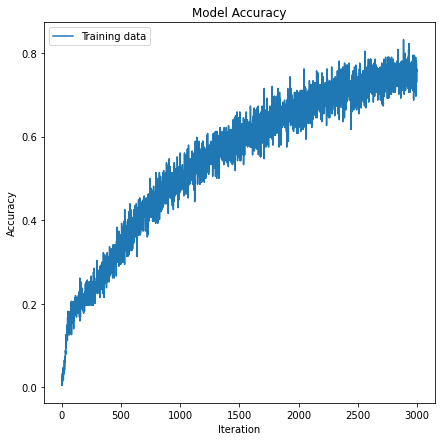

Accuracy on the test data: 0.3281


In [10]:
# train model
#learning_rate = 0.2
batch_size = 100
number_iterations = 3000
verbose = False
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.Adadelta())
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='sgd')
model.compile(loss= keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer='sgd')
history = model.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=verbose)
#history = model.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=True, validation_data=([phoneme_test_x,fft_test], ph_y_test_hot))


plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(['Training data', 'Test data'], loc='best')
plt.show()

loss, accuracy  = model.evaluate([phoneme_test_x, fft_test], ph_y_test_hot, verbose=False)

print(f'Accuracy on the test data: {accuracy:.4}')

Fine tuning 1...


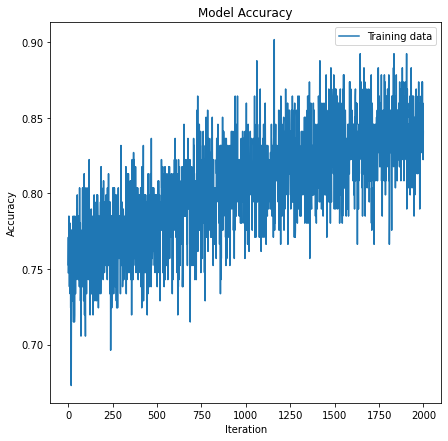

Accuracy on the test data: 0.3201
Fine tuning 2...


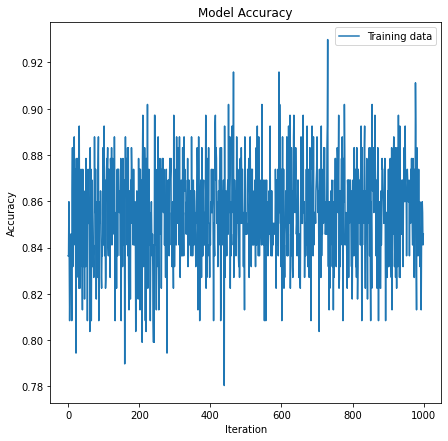

Accuracy on the test data: 0.3275


In [11]:
print("Fine tuning 1...")
# train model
learning_rate = 0.01
batch_size = 100
number_iterations = 2000
verbose = False

#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.Adadelta())
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='sgd')
model.compile(loss= keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.SGD(lr = learning_rate))
history = model.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=verbose)


plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(['Training data', 'Test data'], loc='best')
plt.show()

loss, accuracy  = model.evaluate([phoneme_test_x, fft_test], ph_y_test_hot, verbose=False)

print(f'Accuracy on the test data: {accuracy:.4}')

print("Fine tuning 2...")
# train model
learning_rate = 0.001
batch_size = 100
number_iterations = 1000
verbose = False

#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.Adadelta())
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='sgd')
model.compile(loss= keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.SGD(lr = learning_rate))
history = model.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=verbose)


plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(['Training data', 'Test data'], loc='best')
plt.show()

loss, accuracy  = model.evaluate([phoneme_test_x, fft_test], ph_y_test_hot, verbose=False)

print(f'Accuracy on the test data: {accuracy:.4}')

Model 2: combine different LSTMs.

In [12]:
model2 = Sequential()

input1 = Input(shape=(1024))
input2 = Input(shape=(512))

lstm = LSTM(16, return_sequences=True)(keras.layers.Reshape((64, 16))(input1))
lstm2 = LSTM(16, return_sequences=True)(keras.layers.Reshape((128, 8))(input1))
lstm3 = LSTM(16, return_sequences=True)(keras.layers.Reshape((256, 4))(input1))

lstm = keras.layers.Reshape((64,16))(lstm)
lstm = MaxPooling1D(pool_size=4)(lstm)

lstm2 = keras.layers.Reshape((128,16))(lstm2)
lstm2 = MaxPooling1D(pool_size=8)(lstm2)

lstm3 = keras.layers.Reshape((256,16))(lstm3)
lstm3 = MaxPooling1D(pool_size=4)(lstm3)


y = Concatenate(axis=1)([lstm, lstm2, lstm3])
y = MaxPooling1D(pool_size=8)(y)
y = Dropout(0.5)(y)
y = Flatten()(y)
y = Dense(units=39, use_bias=True, activation='relu')(y)
y = Activation('softmax')(y)
model2 = keras.Model(inputs=[input1,input2], outputs=y)
model2.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 64, 16)       0           input_3[0][0]                    
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 128, 8)       0           input_3[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 256, 4)       0           input_3[0][0]                    
_______________________________________________________________________________________

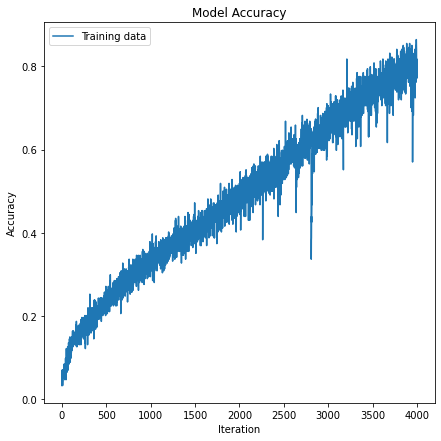

Accuracy on the test data: 0.2737


In [13]:
# train model
#learning_rate = 0.2
batch_size = 100
number_iterations = 4000
verbose = False
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.Adadelta())
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='sgd')
model2.compile(loss= keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer='sgd')
history = model2.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=verbose)
#history = model.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=True, validation_data=([phoneme_test_x,fft_test], ph_y_test_hot))


plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(['Training data', 'Test data'], loc='best')
plt.show()

loss, accuracy  = model2.evaluate([phoneme_test_x, fft_test], ph_y_test_hot, verbose=False)

print(f'Accuracy on the test data: {accuracy:.4}')

Fine tuning 1...


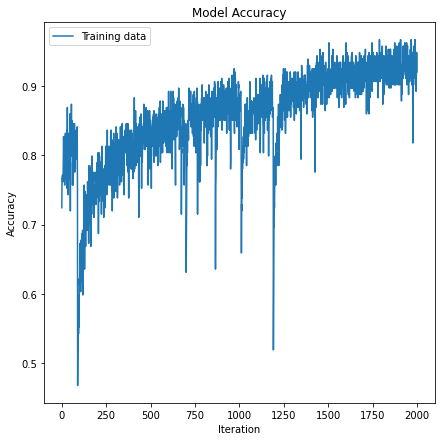

Accuracy on the test data: 0.3049

Fine tuning 2...


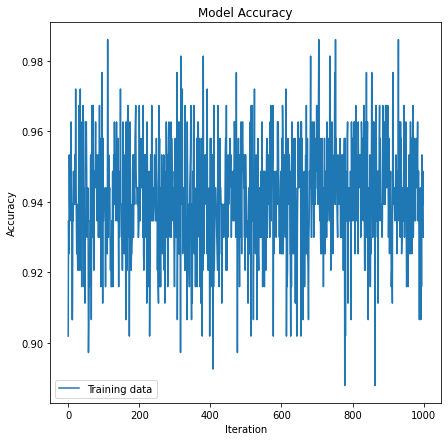

Accuracy on the test data: 0.3038


In [14]:
print("Fine tuning 1...")
# train model
learning_rate = 0.01
batch_size = 100
number_iterations = 2000
verbose = False
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.Adadelta())
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='sgd')
model2.compile(loss= keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.SGD(lr = learning_rate))
history = model2.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=verbose)


plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(['Training data', 'Test data'], loc='best')
plt.show()

loss, accuracy  = model2.evaluate([phoneme_test_x, fft_test], ph_y_test_hot, verbose=False)

print(f'Accuracy on the test data: {accuracy:.4}')


print("\nFine tuning 2...")
learning_rate = 0.001
batch_size = 100
number_iterations = 1000
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.Adadelta())
#model.compile(loss= keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='sgd')
model2.compile(loss= keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.SGD(lr = learning_rate))
history = model2.fit([phoneme_train_x, fft_train], ph_y_train_hot, batch_size=batch_size, epochs=number_iterations, verbose=verbose)


plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(['Training data', 'Test data'], loc='best')
plt.show()

loss, accuracy  = model2.evaluate([phoneme_test_x, fft_test], ph_y_test_hot, verbose=False)

print(f'Accuracy on the test data: {accuracy:.4}')

#Combine random forests and neuronal nets

Note: Looking at the test data and choosing the best is cheating. Instead one should find an explanation why a certain model is chosen or use cross-validation on the training set.

We take the average between the two NNs and two RFs:

In [15]:
nn_pred = model.predict([phoneme_test_x,fft_test])
nn_pred2 = model2.predict([phoneme_test_x,fft_test])

nn_pred_train = model.predict([phoneme_train_x,fft_train])
nn_pred2_train = model2.predict([phoneme_train_x,fft_train])

def get_accuracy_add4(pred_val1, pred_val2, pred_val3, pred_val4,  true_val):
  count = 0 
  for j in range(0, true_val.shape[0]):
    pred_val = pred_val1[j] + pred_val2[j] + pred_val3[j] + pred_val4[j]
    max_val = np.max(pred_val)
    index_pred = 0
    index_true = 0
    for k in range(0,39):
      if max_val == pred_val[k]:
        index_pred = k
      if 1 == true_val[j][k]:
        index_true = k
    if index_pred == index_true:
      count += 1
  return f'{count / true_val.shape[0]:1.4f}'


print("Accuracy 2 NN + 2 short FFT: " + get_accuracy_add4(nn_pred, nn_pred2, prob_clf_short_fft2, prob_clf_short_fft3, ph_y_test_hot))
print("Train accuracy:              " + get_accuracy_add4(nn_pred_train, nn_pred2_train, prob_clf_short_fft_train2, prob_clf_short_fft_train3, ph_y_train_hot))

Accuracy 2 NN + 2 short FFT: 0.3639
Train accuracy:              1.0000


Playing around with different combinations:

In [16]:
nn_pred = model.predict([phoneme_test_x,fft_test])
nn_pred2 = model2.predict([phoneme_test_x,fft_test])

def get_accuracy(pred_val, true_val):
  count = 0 
  for j in range(0, pred_val.shape[0]):
    max_val = np.max(pred_val[j])
    index_pred = 0
    index_true = 0
    for k in range(0,39):
      if max_val == pred_val[j][k]:
        index_pred = k
      if 1 == true_val[j][k]:
        index_true = k
    if index_pred == index_true:
      count += 1
  return f'{count / pred_val.shape[0]:1.4f}'

def get_accuracy_max(pred_val1, pred_val2, true_val):
  count = 0 
  for j in range(0, true_val.shape[0]):
    max_val1 = np.max(pred_val1[j])
    max_val2 = np.max(pred_val2[j])
    index_pred1 = 0
    index_pred2 = 0
    index_true = 0
    for k in range(0,39):
      if max_val1 == pred_val1[j][k]:
        index_pred1 = k
      if max_val2 == pred_val2[j][k]:
        index_pred2 = k
      if 1 == true_val[j][k]:
        index_true = k
    if max_val1 > max_val2:
      if index_pred1 == index_true:
        count += 1
    else:
      if index_pred2 == index_true:
        count += 1
  return f'{count / true_val.shape[0]:1.4f}'

def get_accuracy_add(pred_val1, pred_val2, true_val):
  count = 0 
  for j in range(0, true_val.shape[0]):
    pred_val = pred_val1[j] + pred_val2[j]
    max_val = np.max(pred_val)
    index_pred = 0
    index_true = 0
    for k in range(0,39):
      if max_val == pred_val[k]:
        index_pred = k
      if 1 == true_val[j][k]:
        index_true = k
    if index_pred == index_true:
      count += 1
  return f'{count / true_val.shape[0]:1.4f}'

def get_accuracy_add3(pred_val1, pred_val2, pred_val3, true_val):
  count = 0 
  for j in range(0, true_val.shape[0]):
    pred_val = pred_val1[j] + pred_val2[j] + pred_val3[j]
    max_val = np.max(pred_val)
    index_pred = 0
    index_true = 0
    for k in range(0,39):
      if max_val == pred_val[k]:
        index_pred = k
      if 1 == true_val[j][k]:
        index_true = k
    if index_pred == index_true:
      count += 1
  return f'{count / true_val.shape[0]:1.4f}'

def get_accuracy_add4(pred_val1, pred_val2, pred_val3, pred_val4,  true_val):
  count = 0 
  for j in range(0, true_val.shape[0]):
    pred_val = pred_val1[j] + pred_val2[j] + pred_val3[j] + pred_val4[j]
    max_val = np.max(pred_val)
    index_pred = 0
    index_true = 0
    for k in range(0,39):
      if max_val == pred_val[k]:
        index_pred = k
      if 1 == true_val[j][k]:
        index_true = k
    if index_pred == index_true:
      count += 1
  return f'{count / true_val.shape[0]:1.4f}'

def get_accuracy_add5(pred_val1, pred_val2, pred_val3, pred_val4, pred_val5,  true_val):
  count = 0 
  for j in range(0, true_val.shape[0]):
    pred_val = pred_val1[j] + pred_val2[j] + pred_val3[j] + pred_val4[j] + pred_val5[j]
    max_val = np.max(pred_val)
    index_pred = 0
    index_true = 0
    for k in range(0,39):
      if max_val == pred_val[k]:
        index_pred = k
      if 1 == true_val[j][k]:
        index_true = k
    if index_pred == index_true:
      count += 1
  return f'{count / true_val.shape[0]:1.4f}'

print("Accuracy NN + 3 short FFT: " + get_accuracy_add4(nn_pred, nn_pred2, prob_clf_short_fft2, prob_clf_short_fft3, ph_y_test_hot))

print("Accuracy NN:               " + get_accuracy(nn_pred, ph_y_test_hot))
print("Accuracy NN2:              " + get_accuracy(nn_pred2, ph_y_test_hot))
print("Acc max(NN,RF_FFT):        " + get_accuracy_max(nn_pred, prob_best_clf_fft, ph_y_test_hot))

print("Accuracy NN +  RF_FFT:     " + get_accuracy_add(nn_pred, prob_best_clf_fft, ph_y_test_hot))
print("Accuracy NN +  short FFT:  " + get_accuracy_add(nn_pred, prob_clf_short_fft, ph_y_test_hot))
print("Accuracy NN +  short FFT:  " + get_accuracy_add(nn_pred, prob_clf_short_fft2, ph_y_test_hot))
print("Accuracy NN + 2 short FFT: " + get_accuracy_add3(nn_pred, prob_clf_short_fft2, prob_clf_short_fft3, ph_y_test_hot))
print("Accuracy NN + 3 short FFT: " + get_accuracy_add4(nn_pred, prob_clf_short_fft, prob_clf_short_fft2, prob_clf_short_fft3, ph_y_test_hot))
print("Accuracy NN + 4 short FFT: " + get_accuracy_add5(nn_pred, prob_clf_short_fft, prob_clf_short_fft2, prob_clf_short_fft3, prob_clf_short_fft4, ph_y_test_hot))

print("Accuracy NN +  short FFT:  " + get_accuracy_add(nn_pred, nn_pred2, ph_y_test_hot))
print("Accuracy NN +  short FFT:  " + get_accuracy_add(nn_pred2, prob_clf_short_fft2, ph_y_test_hot))
print("Accuracy NN +  short FFT:  " + get_accuracy_add3(nn_pred2, prob_clf_short_fft2, prob_clf_short_fft3, ph_y_test_hot))
print("Accuracy NN +  short FFT:  " + get_accuracy_add4(nn_pred, nn_pred2, prob_clf_short_fft2, prob_clf_short_fft3, ph_y_test_hot))
print("Accuracy NN +  short FFT:  " + get_accuracy_add5(nn_pred, nn_pred2, prob_clf_short_fft2, prob_clf_short_fft3, prob_clf_short_fft4, ph_y_test_hot))


Accuracy NN + 3 short FFT: 0.3639
Accuracy NN:               0.3275
Accuracy NN2:              0.3038
Acc max(NN,RF_FFT):        0.3281
Accuracy NN +  RF_FFT:     0.3402
Accuracy NN +  short FFT:  0.3402
Accuracy NN +  short FFT:  0.3476
Accuracy NN + 2 short FFT: 0.3555
Accuracy NN + 3 short FFT: 0.3571
Accuracy NN + 4 short FFT: 0.3597
Accuracy NN +  short FFT:  0.3418
Accuracy NN +  short FFT:  0.3307
Accuracy NN +  short FFT:  0.3465
Accuracy NN +  short FFT:  0.3639
Accuracy NN +  short FFT:  0.3687


#TODO: use sophisticated features (package tsfresh)

#TODO: use SSA decomposition (?)

In [17]:
# Function for column times row matrix multiplication, returns a rank-one matrix (or 0).
# Parameters: 
#    c: column (np.array)
#    r: row (np.array) 
def c_r_mul(c,r):
    A = np.zeros([len(c), len(r)])
    for j in range(0,len(c)):
        for  k in range(0,len(r)):
            A[j,k] = c[j] * r[k]
    return A

#w-product between two time series x,y, see p.38
def w_prod(x, y, L):
    N = len(x)
    K = N - L + 1
    Ls = min(L, K)
    Ks = max(L, K)
    result = 0
    for j in range(1,N+1):
        if j < Ls:
            w = j
        elif j <= Ks:
            w = Ls
        else:
            w = N-j+1
        result = result + w*x[j-1]*y[j-1]
    return result

# w-correlation between two time series
def w_corr(x, y, L):
    return w_prod(x,y,L)/np.sqrt(w_prod(x,x,L)*w_prod(y,y,L))

# Returns eigenvalues and -vectors of the lagged covariance matrix and the elementary series.
# Parameters: 
#    x: time series
#    L: lag parameter
def w_correlation_matrix(d, x_el_series, L):
    matrix = np.zeros([d,d])
    for k in range(0,d):
        for j in range(0,d): 
            matrix[j,k] = w_corr(x_el_series[j],x_el_series[k],L)
    return matrix

# Returns eigenvalues and -vectors of the lagged covariance matrix and the elementary series.
# Parameters: 
#    x: time series
#    L: lag parameter
def SSA(x, L):
    N = len(x)
    K = N - L + 1
    Ls = min(L, K)
    Ks = max(L, K)
    X = np.zeros([L,K]) # trajectory matrix
    for j in range(0,L):
        for k in range(0,K):
           X[j,k] = x[j+k]
    S = np.matmul(X, np.transpose(X))   # lagged covariance matrix
    [eig_val, eig_vec] = np.linalg.eig(S / (N) ) # eigenvalues and -vectors; eig_vec[:,0] is the first eigenvector
    # convert into real numbers
    eig_val = np.real(eig_val)
    eig_vec = np.real(eig_vec)
    # sort such that eig_val[0] is the largest eigenvalue 
    idx = eig_val.argsort()[::-1]   
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    d = np.linalg.matrix_rank(S) # TODO

    X_el = [] # elementary matrices

    for j in range(0,d):
        temp = c_r_mul(eig_vec[:,j], eig_vec[:,j])
        X_el.append(np.matmul(temp, X))
### X can be econstructed as X_rec:
#X_rec = np.zeros(X.shape)
#for j in range(0,d):
#    X_rec = X_rec + X_el[j]
#print(np.sum((np.abs(X-X_rec))))  # should be small

# construct decomposed time series
    x_el_series = [] # series corrsponding to the elementary matrices

    if L<K: 
      for j in range(0,d):
        M = X_el[j]
        temp = np.zeros(N)
        for k in range(1,N+1):
            if k < Ls:
                for j in range(0,k):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / (k)
            elif k <= Ks:
                for j in range(0,Ls):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / Ls
            else:
                for j in range(k-Ks, N-Ks+1):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / (N-k+1)

        x_el_series.append(temp)
    else: 
      for j in range(0,d):
        M = X_el[j]
        temp = np.zeros(N)
        for k in range(1,N+1):
            if k < Ls:
                for j in range(0,k):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / (k)
            elif k <= Ks:
                for j in range(0,Ls):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / Ls
            else:
                for j in range(k-Ks, N-Ks+1):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / (N-k+1)

        x_el_series.append(temp) 

    return [d, eig_val, eig_vec, x_el_series, X_el]

# Returns eigenvalues and -vectors of the lagged covariance matrix and the elementary series.
# Parameters: 
#    x: time series
#    L: lag parameter
#    number_eigenvalues: number of largest eigenvalues used
def SSA(x, L, number_eigenvalues, number_groups, ratios = None):
    N = len(x)
    K = N - L + 1
    Ls = min(L, K)
    Ks = max(L, K)
    X = np.zeros([L,K]) # trajectory matrix
    for j in range(0,L):
        for k in range(0,K):
           X[j,k] = x[j+k]
    S = np.matmul(X, np.transpose(X))   # lagged covariance matrix
    [eig_val, eig_vec] = np.linalg.eig(S / (N) ) # eigenvalues and -vectors; eig_vec[:,0] is the first eigenvector
    # convert into real numbers
    eig_val = np.real(eig_val)
    eig_vec = np.real(eig_vec)
    # sort such that eig_val[0] is the largest eigenvalue 
    idx = eig_val.argsort()[::-1]   
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    d = number_eigenvalues

    X_el = [] # elementary matrices

    for j in range(0,d):
        temp = c_r_mul(eig_vec[:,j], eig_vec[:,j])
        X_el.append(np.matmul(temp, X))
### X can be econstructed as X_rec:
#X_rec = np.zeros(X.shape)
#for j in range(0,d):
#    X_rec = X_rec + X_el[j]
#print(np.sum((np.abs(X-X_rec))))  # should be small

# construct decomposed time series
    x_el_series = [] # series corrsponding to the elementary matrices

    if L<K: 
      for j in range(0,d):
        M = X_el[j]
        temp = np.zeros(N)
        for k in range(1,N+1):
            if k < Ls:
                for j in range(0,k):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / (k)
            elif k <= Ks:
                for j in range(0,Ls):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / Ls
            else:
                for j in range(k-Ks, N-Ks+1):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / (N-k+1)

        x_el_series.append(temp)
    else: 
      for j in range(0,d):
        M = X_el[j]
        temp = np.zeros(N)
        for k in range(1,N+1):
            if k < Ls:
                for j in range(0,k):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / (k)
            elif k <= Ks:
                for j in range(0,Ls):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / Ls
            else:
                for j in range(k-Ks, N-Ks+1):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / (N-k+1)

        x_el_series.append(temp) 
    
    ratio_max = np.zeros(number_groups-1)
    ratio_indices =  np.zeros(number_groups-1, dtype=np.int)
    for j in range(1,d):
        ratio  = eig_val[j-1]/eig_val[j]
        for group in range(0, number_groups-1):
           if ratio > ratio_max[group]:
             for gr in range(0, number_groups-2-group):
               ratio_max[number_groups-2 -gr] = ratio_max[number_groups-2 -gr-1] 
               ratio_indices[number_groups-2 -gr] = ratio_indices[number_groups-2 -gr-1] 
             ratio_max[group] = ratio
             ratio_indices[group] = j
             break
    idx2 = ratio_indices.argsort()   
    ratio_indices = ratio_indices[idx2]
    if ratios != None:
      ratio_indices = ratios
    x_groups = np.zeros([number_groups, len(x)])
    for group in range(0, number_groups):
      if group == 0:
        for  j in range(0,ratio_indices[0]+1):
          x_groups[group,:] =  x_groups[group,:] + x_el_series[j]
      elif group < number_groups-1:
        for  j in range(ratio_indices[group-1]+1, ratio_indices[group]+1):
          x_groups[group,:] =  x_groups[group,:] + x_el_series[j]
      else:
        for  j in range(ratio_indices[group-1]+1, d):
          x_groups[group,:] =  x_groups[group,:] + x_el_series[j]
    return [d, eig_val, eig_vec, x_el_series, X_el, x_groups, ratio_indices]

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def eigen_value_grouping(d, x_el_series, L, n_clusters, eig_val = None):
    X = w_correlation_matrix(d, x_el_series, L)
    X = 1 - X # distance matrix (similarity matrix)
   # print(X)
    if not (eig_val is None):
        for j in range(0,d):
            for k in range(0,d):
                X[j,k] = X[j,k] * 1#max(1, (pow(eig_val[min(j,k)] - eig_val[max(j,k)], 0.5))) #pow((eig_val[min(j,k)] - eig_val[max(j,k)]), 0.17)
   # print(X)
    embedding = MDS(n_components=L) # embed into R^L
    X_transformed = embedding.fit_transform(X)
  #  plt.scatter(X_transformed[1:,0], X_transformed[1:,1])
 #   plt.title("2-dimensional embedding of the eigenvalues")
  #  plt.show()

 #   print(X_transformed[0,0])
 #   print(X_transformed[0,1])
   # if not (eig_val is None):
    #    print(eig_val[0])

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_transformed)
    eig_val_clusters = kmeans.predict(X_transformed)

   # clustering = DBSCAN(eps=5, min_samples=1).fit(X)
   # print(clustering.labels_)
   # print(eig_val_clusters)

    silhouette_avg = silhouette_score(X_transformed, eig_val_clusters)

#    plt.scatter(X_transformed[3:,0], X_transformed[3:,1], c=eig_val_clusters[3:], s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
 #   plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5)
 #   plt.title("Clustered eigenvalues")
 #   plt.show()
    x_groups = np.zeros([n_clusters, len(x_el_series[0])])
    for k in range(0, len(eig_val_clusters)):
      group = eig_val_clusters[k]
      x_groups[group,:] =  x_groups[group,:] + x_el_series[k]
    
    group_power = np.zeros(n_clusters)
    
    for group in range(0, n_clusters): 
      for j in range(0, len(eig_val)):
        if group ==  eig_val_clusters[j]:
          group_power[group] += eig_val[j]

    idx = group_power.argsort()[::-1]  

    for j in range(0, len(x_groups[0,:])): 
          x_groups[:,j] = x_groups[idx,j]
    return x_groups, silhouette_avg, eig_val_clusters

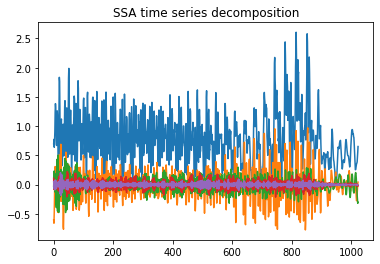

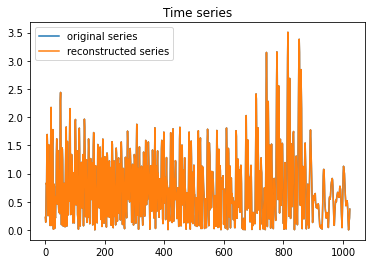

Difference between x and its reconstuction: sum = 1.2214568766155676e-11, average = 1.1928289810698902e-14
[3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 1 1 3 3 3
 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 3 3 3 3 3 3
 3 0 0 2 2 2 2 2 2 2 3 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3]


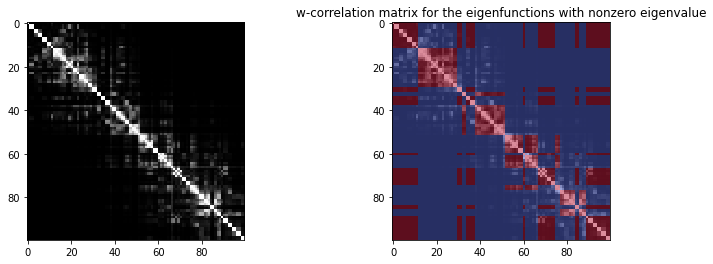

In [18]:
x_test_SSA = np.abs(phoneme_train_x[0,:])

L = 100  # Lag paramter
number_groups = 5

ratios=None#[0,1,5,10]
[d, eig_val, eig_vec, x_el_series, X_el, x_groups, ratio_indices] = SSA(x_test_SSA, L, L, number_groups, ratios=ratios)

import matplotlib.cm as cm
w_corr_matrix = w_correlation_matrix(d, x_el_series, L)
x_groups, silhouette_avg, eig_val_clusters = eigen_value_grouping(d, x_el_series, L, number_groups, eig_val = eig_val)

#fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for j in range(0,number_groups):
    plt.plot(x_groups[j])
    plt.title('SSA time series decomposition')
plt.show()
 ### Plot FFT of the decompositions:
    #yf = fft(x_groups[j])
    #plt.plot(np.abs(yf[0:int(len(yf)/2)]))
    #plt.title('FFT of SSA decomposition')
   # plt.show()    
   # print(eig_val_clusters)

w_corr_matrix3 = np.zeros(w_corr_matrix.shape)

for j in range(0, L):
  group = eig_val_clusters[j]
  for k in range(0, L):
      group2 = eig_val_clusters[k]
      if group == group2:
        w_corr_matrix3[j,k] = 1

x_recons = np.zeros(len(x_test_SSA))
for j in range(0,number_groups):
    x_recons = x_recons + x_groups[j]
plt.plot(x_test_SSA, label = 'original series')
plt.plot(x_recons, label = 'reconstructed series')
plt.legend()
plt.title('Time series')
plt.show()

print("Difference between x and its reconstuction: sum = " + str(np.sum((np.abs(x_test_SSA-x_recons)))) + ", average = " + str(np.average((np.abs(x_test_SSA-x_recons)))))  # should be small


print(eig_val_clusters)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r)
axs[1].imshow(w_corr_matrix3, interpolation='nearest', cmap=cm.coolwarm, alpha=0.9)
axs[1].imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r, alpha =0.5)

plt.title("w-correlation matrix for the eigenfunctions with nonzero eigenvalue")
plt.show()
  

In [19]:
# We construct a time series x as the sum of two structured time series x1 and x2.
N = 1000  # number of points
x = np.zeros(N)
x1 = np.zeros(N)
x2 = np.zeros(N)

for j in range(0,len(x1)):
    x1[j] = np.sin(j/(N/60))
    x2[j] = 3*(j/N-0.5)**2#3* j/ len(x1) 
    x[j] = x1[j] + x2[j]

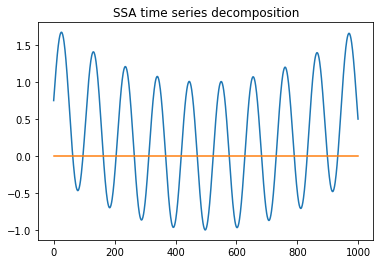

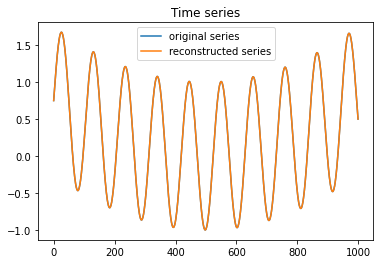

Difference between x and its reconstuction: sum = 9.730532352092425e-13, average = 9.730532352092425e-16
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0]


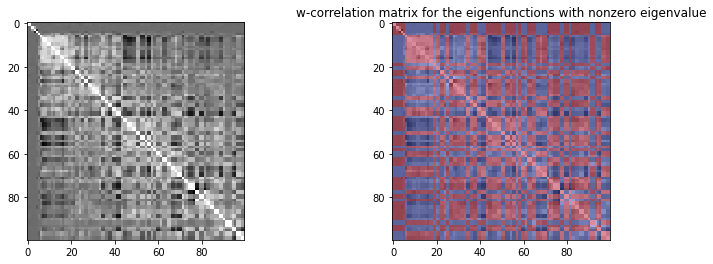

In [20]:
x_test_SSA = x

L = 100  # Lag paramter
number_groups = 2

ratios=None#[0,1,5,10]
[d, eig_val, eig_vec, x_el_series, X_el, x_groups, ratio_indices] = SSA(x_test_SSA, L, L, number_groups, ratios=ratios)

import matplotlib.cm as cm
w_corr_matrix = w_correlation_matrix(d, x_el_series, L)
x_groups, silhouette_avg, eig_val_clusters = eigen_value_grouping(d, x_el_series, L, number_groups, eig_val = eig_val)

#fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for j in range(0,number_groups):
    plt.plot(x_groups[j])
    plt.title('SSA time series decomposition')
plt.show()
    
    #yf = fft(x_groups[j])
    #plt.plot(np.abs(yf[0:int(len(yf)/2)]))
    #plt.title('FFT of SSA decomposition')
   # plt.show()    
   # print(eig_val_clusters)

w_corr_matrix3 = np.zeros(w_corr_matrix.shape)

for j in range(0, L):
  group = eig_val_clusters[j]
  for k in range(0, L):
      group2 = eig_val_clusters[k]
      if group == group2:
        w_corr_matrix3[j,k] = 1

x_recons = np.zeros(len(x_test_SSA))
for j in range(0,number_groups):
    x_recons = x_recons + x_groups[j]
plt.plot(x_test_SSA, label = 'original series')
plt.plot(x_recons, label = 'reconstructed series')
plt.legend()
plt.title('Time series')
plt.show()

print("Difference between x and its reconstuction: sum = " + str(np.sum((np.abs(x_test_SSA-x_recons)))) + ", average = " + str(np.average((np.abs(x_test_SSA-x_recons)))))  # should be small


print(eig_val_clusters)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r)
axs[1].imshow(w_corr_matrix3, interpolation='nearest', cmap=cm.coolwarm, alpha=0.9)
axs[1].imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r, alpha =0.5)

plt.title("w-correlation matrix for the eigenfunctions with nonzero eigenvalue")
plt.show()
  